<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/My Drive/Colab Notebooks/accent/src

### Import packages

In [1]:
import re, zipfile, os, io, time, string, numpy as np, matplotlib.ticker as ticker, \
            matplotlib.pyplot as plt

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# from utils import process_raw, generate_input, get_max_len, process_data, convert

from token_list import strip_tokens
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# x = ['Khoan no cua KH se den han vao 01/08/2019. So tien  2.999.898 VND, TK 12345678912. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH se den han trong 2 ngay toi. So tien  2.999.898 VND, TK 12345678912. Bo qua neu da TT. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH da qua han 1 ngay. TK 12345678912, so tien2.999.898 VND. Bo qua neu da TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 6 ngay va bi tinh phat 250,000. TK 12345678912, so tien 2.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'KH da qua han 5 ky no. TK 12345678912, so tien 12.999.898VND. Vui long TT ngay lap tuc. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da bi tinh phat do lien tuc vi pham. TK12345678912, so tien 12.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 91 ngay. Vui long TT toan bo29.999.898VND vao TK 12345678912 hom nay. Thong tin chi tiet, lien he 18006288',
# 'Chung toi vua nhan thanh toan khoan vay cua KH tu TK12345678912. TUY NHIEN, KH van con thieu 29.999.898VND. Vui long TT toan ngay lap tuc. Cam on']

### Custom functions

In [3]:
def process_raw(raw_data):
    raw_data = [seq.lower().strip() for seq in raw_data]

    # Creating a space between a word and the punctuation following it
    # Eg: "he is a boy." => "he is a boy ."
    raw_data = [re.sub(r"([?.!,¿])", r" \1 ", seq) for seq in raw_data]
    raw_data = [re.sub(r'[" "]+', " ", seq) for seq in raw_data]

    # Replacing everything with space except (characters, ".", "?", "!", ",")
    filtered_punctuations = string.punctuation
    exclude = [',', '!', '.', '?']

    for c in filtered_punctuations:
        if c in exclude:
            filtered_punctuations = filtered_punctuations.replace(c, '')

    table = str.maketrans('', '', filtered_punctuations)
    raw_data = [seq.translate(table) for seq in raw_data]
    
    # Append start and end tokens to sequences
    processed_raw = []
    for seq in raw_data:
        words = seq.split()
        words = [word.strip() for word in words]
        processed_raw.append(' '.join(words))

    # processed_raw = ['<s> ' + seq + ' <e>' for seq in processed_raw]
    processed_raw = ['<s> ' + seq + ' <e>' for seq in processed_raw]

    return processed_raw

In [4]:
def generate_input(processed_raw):
    output = ''
    for char in processed_raw:
        if char in strip_tokens:
            output += strip_tokens[char]
        else:
            output += char          
    return output

In [5]:
def get_max_len(input_data, get_index=False): 
    longest = [len(data.split()) for data in input_data]
    if get_index:
        print(longest.index(max(longest)))
    return max(longest)

In [6]:
def tokenize_pad_data(data, pad_len=None):
    tk = Tokenizer(char_level=False, filters='')
    tk.fit_on_texts(data)
    data = tk.texts_to_sequences(data)
    data = pad_sequences(data, padding='post', maxlen=pad_len)
    return data, tk

In [7]:
def process_data(processed_input, processed_target, pad_len=None):    
    tokenized_input, input_tokenizer = tokenize_pad_data(data=processed_input, pad_len=pad_len)
    tokenized_target, target_tokenizer = tokenize_pad_data(data=processed_target, pad_len=pad_len)
    return tokenized_input, input_tokenizer, tokenized_target, target_tokenizer

In [8]:
def convert(tokenizer, tokenized_data, send_back=False):
    original = []
    
    print('Tokenized Data: {}'.format(tokenized_data))
    print('\n')
    
    for token in tokenized_data:
        if token != 0:
            if token in tokenizer.index_word:
                original.append(tokenizer.index_word[token])
            else:
                original.append('<unk>')
                    
    print('Original Data: {}'.format(original))
    
    if send_back:
        return original

In [9]:
def evaluate(sentence):
    attention_plot = np.zeros((max_process_seq, max_process_seq))

#     sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_process_seq, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']], 0)

    for t in range(max_process_seq):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<e>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
      
    return result, sentence, attention_plot

In [10]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [11]:
def restore(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Environment variables

In [12]:
# Define data arguements
# Set random seed
np.random.seed(50)
data_file = '../data/raw/raw_train.txt'

tf.__version__

'2.0.0-rc1'

### Load and process dataset

In [13]:
# Load dataset
counter = 0
max_seq_len = 40
no_seq = 100000
raw_data = []

# Load raw data and read first 100000 sequences with 40 or less words
with open(data_file, 'r', encoding='utf-8') as f:    
    while counter != no_seq:
        line = f.readline()
        if len(line.split()) <= max_seq_len:
            raw_data.append(line)
            counter += 1
        else:
            continue

In [14]:
# Process dataset
# From the 1000000 sequences, randomly pick 20000
random_pick = 20000
random_idx = np.random.choice(no_seq, random_pick, replace=False)
raw_data = [raw_data[i] for i in random_idx]

# Shuffle raw data prior to processing
np.random.shuffle(raw_data)

# Process raw and input data
filtered_raw = process_raw(raw_data)
processed_inp = [generate_input(seq) for seq in filtered_raw]

# Get max sequence length after processing
max_process_seq = get_max_len(processed_inp, get_index=False)
print('Max input sequence length: {}'.format(get_max_len(processed_inp)))
print('Max target sequence length: {}'.format(get_max_len(filtered_raw)))

Max input sequence length: 52
Max target sequence length: 52


In [15]:
print('Input Sample:')
print(processed_inp[-1])
print('\n')
print('Target Sample:')
print(filtered_raw[-1])

Input Sample:
<s> tin hieu so la tin hieu da duoc lay mau va luong tu hoa . <e>


Target Sample:
<s> tín hiệu số là tín hiệu đã được lấy mẫu và lượng tử hóa . <e>


In [16]:
# Tokenize/pad input and target data, generates corresponding tokenizers
tokenized_input, input_tokenizer, tokenized_target, target_tokenizer = process_data(processed_input=processed_inp, 
                                                            processed_target=filtered_raw, pad_len=max_process_seq)

In [17]:
train_data_len = round((.8 * random_pick))
val_test_data_len = round((.1 * random_pick))

train_inp_data, train_tar_data = tokenized_input[:train_data_len], tokenized_target[:train_data_len]
val_inp_data, val_tar_data = tokenized_input[train_data_len:(train_data_len+val_test_data_len)], \
                                    tokenized_target[train_data_len:(train_data_len+val_test_data_len)]
test_inp_data, test_tar_data = tokenized_input[-val_test_data_len:], tokenized_target[-val_test_data_len:]

print('Number of training sequences: {}'.format(len(train_inp_data)))
print('Number of val sequences: {}'.format(len(val_inp_data)))
print('Number of test sequences: {}'.format(len(test_inp_data)))

Number of training sequences: 16000
Number of val sequences: 2000
Number of test sequences: 2000


In [18]:
convert(input_tokenizer, train_inp_data[0])

Tokenized Data: [   2   54  421   31   79  212  139   84   43  267   69  327   15    4
   15  817  376  983  212   66   16 2053   24   67   54   20  192   68
   44   27   87  120    4   53   82    1    1    1    3    0    0    0
    0    0    0    0    0    0    0    0    0    0]


Original Data: ['<s>', 'hoa', 'kieu', 'o', 'hai', 'ngoai', 'danh', 'dien', 've', 'ung', 'ho', 'quang', 'tu', ',', 'tu', 'hi', 'cang', 'ghet', 'ngoai', 'nhan', 'da', 'mom', 'cho', 'trung', 'hoa', 'nhung', 'y', 'tuong', 'phan', 'dong', 'hien', 'phap', ',', 'dan', 'chu', '.', '.', '.', '<e>']


In [19]:
train_buffer_sz = len(train_inp_data)
val_buffer_sz = len(val_inp_data)
test_buffer_sz = len(test_inp_data)
batch_sz = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_data, train_tar_data)).shuffle(train_buffer_sz)
train_dataset = train_dataset.batch(batch_sz, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_data, val_tar_data)).shuffle(val_buffer_sz)
val_dataset = val_dataset.batch(batch_sz, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_inp_data, test_tar_data)).shuffle(test_buffer_sz)
test_dataset = test_dataset.batch(batch_sz, drop_remainder=True)

In [20]:
example_input_batch, example_target_batch = next(iter(train_dataset))
# example_input_batch.shape, example_target_batch.shape

example_val_inp_batch, example_val_tar_batch = next(iter(val_dataset))
# example_val_inp_batch.shape, example_val_tar_batch.shape

example_test_inp_batch, example_test_tar_batch = next(iter(test_dataset))
# example_test_inp_batch.shape, example_test_tar_batch.shape

### Define model and model parameters

In [21]:
embedding_dim = 256
units = 1024
dropout = 0.2
inp_vocab_sz = len(input_tokenizer.index_word)+1
tar_vocab_sz = len(target_tokenizer.index_word)+1

print('Input vocabulary: {}'.format(inp_vocab_sz))
print('Target vocabulary: {}'.format(tar_vocab_sz))

Input vocabulary: 13334
Target vocabulary: 16384


In [22]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super().__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)
            
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [23]:
encoder = Encoder(inp_vocab_sz, embedding_dim, units, batch_sz)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden[0].shape))

Encoder output shape: (batch size, sequence length, units) (32, 52, 1024)
Encoder Hidden state shape: (batch size, units) (1024,)


In [24]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [25]:
attention_layer = BahdanauAttention(64)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 52, 1)


In [26]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super().__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [27]:
decoder = Decoder(tar_vocab_sz, embedding_dim, units, batch_sz)

sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_sz, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 16384)


### Define loss and accuracy metrics

In [28]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

### Define checkpoint options

In [29]:
checkpoint_dir = './training_checkpoints'
  
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_dir, max_to_keep=1)

### Training function and loop

In [30]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0.0
    acc = 0.0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']] * batch_sz, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_object(targ[:, t], predictions)           
    
            train_accuracy.update_state(targ[:, t], predictions)
            acc += train_accuracy.result()
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
      
    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))
    
    batch_loss = loss / int(targ.shape[1])
    batch_acc = acc / int (targ.shape[1])
    
    return batch_loss, batch_acc

In [31]:
@tf.function
def test_step(inp, targ, enc_hidden):
  loss = 0.0
  acc = 0.0
  
  enc_output, enc_hidden = encoder(inp, enc_hidden)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']] * batch_sz, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_object(targ[:, t], predictions)
    
    val_accuracy(targ[:, t], predictions)    
    val_accuracy.update_state(targ[:, t], predictions)
    acc += val_accuracy.result()
            
    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1)
    
  batch_loss = loss / int(targ.shape[1])
  batch_acc = acc / int (targ.shape[1])
    
  return batch_loss, batch_acc

In [41]:
epochs = 50
train_steps_per_epoch = len(train_inp_data)//batch_sz
val_steps_per_epoch = len(val_inp_data)//batch_sz
# best_val_loss = np.inf
best_val_loss = 1.1072
train_epoch_losses = []
train_epoch_accs = []
val_epoch_losses = []
val_epoch_accs = []
early_stop = 0

for epoch in range(epochs):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  train_total_loss = 0.0
  train_total_acc = 0.0
  val_total_loss = 0.0
  val_total_acc = 0.0
    
  # Training
  for (batch, (inp, targ)) in enumerate(train_dataset.take(train_steps_per_epoch)):
    train_batch_loss, train_batch_acc = train_step(inp, targ, enc_hidden)
    train_total_loss += np.average(train_batch_loss)
    train_total_acc += train_batch_acc
        
    if batch % 100 == 0:
      print('Epoch: {}, Batch: {}, Loss: {:.4f}'.format(epoch+1, batch, np.average(train_batch_loss)))
      
  # Training
  train_epoch_loss = train_total_loss/train_steps_per_epoch 
  train_epoch_losses.append(train_epoch_loss)
  
  train_epoch_acc = train_total_acc/train_steps_per_epoch
  train_epoch_accs.append(train_epoch_acc)    
      
  # Validation
  for (_, (inp, targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss, val_batch_acc = test_step(inp, targ, enc_hidden)
    val_total_loss += np.average(val_batch_loss)
    val_total_acc += val_batch_acc
  
  # Validation
  val_epoch_loss = val_total_loss/val_steps_per_epoch    
  val_epoch_losses.append(val_epoch_loss)

  val_epoch_acc = val_total_acc/val_steps_per_epoch
  val_epoch_accs.append(val_epoch_acc)
    
  if val_epoch_loss <= best_val_loss:
    print('New best val loss: {:.4f} --> {:.4f}'.format(best_val_loss, val_epoch_loss))
    best_val_loss = val_epoch_loss
    print('New val loss: {:.4f}'.format(best_val_loss))
    print('Saving model')
    manager.save()
    print('Save completed')
    print('Resetting Early Stop counter')
    early_stop = 0
  else:
    early_stop += 1
    print('Increasing Early Stop count to: {}'.format(early_stop))
    if early_stop == 5:
      print('Loss has not improved for {} epochs, Early Stoppping'.format(early_stop))
      break
      
  train_template = 'Epoch {} Training Loss {:.4f}, Training Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
  print(train_template.format(epoch + 1, train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc))
  print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

  train_accuracy.reset_states()
  val_accuracy.reset_states()

Epoch: 1, Batch: 0, Loss: 2.4326
Epoch: 1, Batch: 100, Loss: 2.5706
Epoch: 1, Batch: 200, Loss: 2.4202
Epoch: 1, Batch: 300, Loss: 2.3954
Epoch: 1, Batch: 400, Loss: 2.5672
Increasing Early Stop count to: 1
Epoch 1 Training Loss 2.5125, Training Acc: 0.5974, Val Loss: 2.4697, Val Acc: 0.6104
Time taken for 1 epoch 399.1164 sec

Epoch: 2, Batch: 0, Loss: 2.0579
Epoch: 2, Batch: 100, Loss: 2.3873
Epoch: 2, Batch: 200, Loss: 1.8886
Epoch: 2, Batch: 300, Loss: 2.3439
Epoch: 2, Batch: 400, Loss: 2.3502
Increasing Early Stop count to: 2
Epoch 2 Training Loss 2.2506, Training Acc: 0.6191, Val Loss: 2.6197, Val Acc: 0.5893
Time taken for 1 epoch 396.6148 sec

Epoch: 3, Batch: 0, Loss: 2.1462
Epoch: 3, Batch: 100, Loss: 2.0875
Epoch: 3, Batch: 200, Loss: 1.9629
Epoch: 3, Batch: 300, Loss: 2.0922
Epoch: 3, Batch: 400, Loss: 2.0766
Increasing Early Stop count to: 3
Epoch 3 Training Loss 1.9951, Training Acc: 0.6424, Val Loss: 2.0730, Val Acc: 0.6639
Time taken for 1 epoch 393.6478 sec

Epoch: 4, 

### Plot loss and accuracy graphs

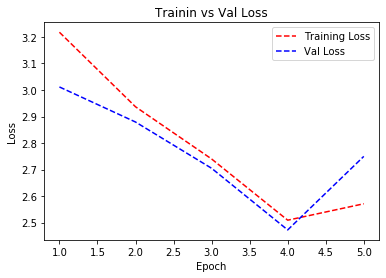

In [35]:
# Plot training vs val loss
epoch_range = [i for i in range(1, len(train_epoch_losses)+1)]
plt.plot(epoch_range, train_epoch_losses, 'r--')
plt.plot(epoch_range, val_epoch_losses, 'b--')
plt.title('Trainin vs Val Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

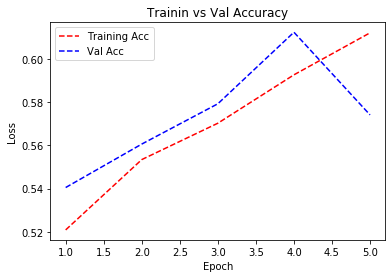

In [36]:
# Plot training vs val accuracy
epoch_range = [i for i in range(1, len(train_epoch_losses)+1)]
plt.plot(epoch_range, train_epoch_accs, 'r--')
plt.plot(epoch_range, val_epoch_accs, 'b--')
plt.title('Trainin vs Val Accuracy')
plt.legend(['Training Acc', 'Val Acc'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluate model and test prediction

In [32]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(manager.latest_checkpoint)

In [33]:
# Testing
test_steps_per_epoch = len(test_inp_data)//batch_sz
test_total_loss = 0.0
test_total_acc = 0.0
test_loss = 0.0
test_acc = 0.0
enc_hidden = encoder.initialize_hidden_state()

for (_, (inp, targ)) in enumerate(test_dataset.take(test_steps_per_epoch)):
  test_batch_loss, test_batch_acc = test_step(inp, targ, enc_hidden)
  test_total_loss += np.average(test_batch_loss)
  test_total_acc += test_batch_acc

# Testing
test_loss = test_total_loss/test_steps_per_epoch    
# test_epoch_losses.append(test_epoch_loss)

test_acc = test_total_acc/test_steps_per_epoch
# test_epoch_accs.append(test_epoch_acc)

print('Testing Loss: {:.4f}, Acc: {:.4f}'.format(test_loss, test_acc))
val_accuracy.reset_states()

Testing Loss: 1.0923, Acc: 0.8271


In [42]:
rand = np.random.randint(0, len(test_inp_data)) # Change here
test = test_inp_data[rand] # Change here
test = convert(input_tokenizer, test, send_back=True)
test = ' '.join(test)
print('Test Sequence: {}'.format(test))

Tokenized Data: [  2  12  32 769  93 448 135  29  10 243  39 110 243 290  56  75  13   1
   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Original Data: ['<s>', 'mot', 'so', 'deo', 'qua', 'nui', 'cao', 'cung', 'duoc', 'dua', 'vao', 'duong', 'dua', 'hau', 'nhu', 'moi', 'nam', '.', '<e>']
Test Sequence: <s> mot so deo qua nui cao cung duoc dua vao duong dua hau nhu moi nam . <e>


Tokenized Data: [   2   11   37 2786  144  543  108   43   10  379   25  155 1231  606
   30  293   13    1    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


Original Data: ['<s>', 'một', 'số', 'đèo', 'qua', 'núi', 'cao', 'cũng', 'được', 'đưa', 'vào', 'đường', 'đua', 'hầu', 'như', 'mỗi', 'năm', '.', '<e>']
Original: <s> một số đèo qua núi cao cũng được đưa vào đường đua hầu như mỗi năm . <e>
Input: <s> mot so deo qua nui cao cung duoc dua vao duong dua hau nhu moi nam . <e>
Predicted translation: một số đẽo quả núi cao cũng được đưa vào đường đua hầu như mỗi năm . <e> 


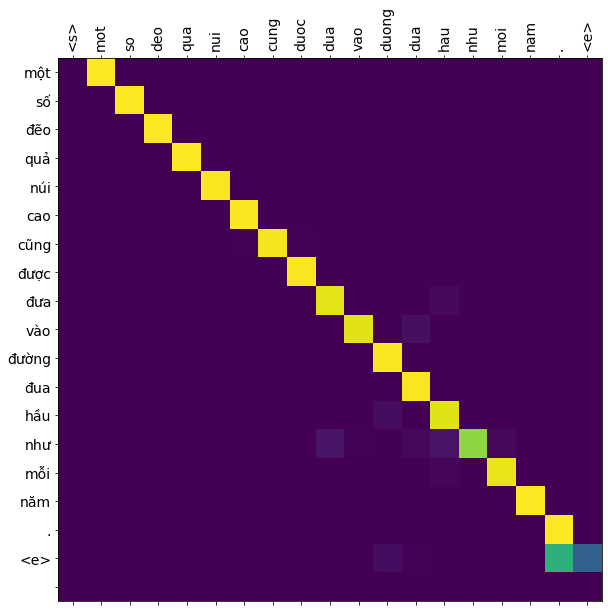

In [43]:
test_tar = convert(target_tokenizer, test_tar_data[rand], send_back=True) # Change here
test_tar = ' '.join(test_tar)
print('Original: {}'.format(test_tar))
restore(test)

In [44]:
một số đèo qua núi cao cũng được đưa vào đường đua hầu như mỗi năm . <e>
một số đẽo quả núi cao cũng được đưa vào đường đua hầu như mỗi năm . <e> 